In [86]:
# imports
import pandas as pd
from matplotlib import pyplot as plt

from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import random
import nltk
import numpy as np
import torch
from torchtext.vocab import build_vocab_from_iterator
import torch.nn as nn
import torch.optim as optim
import spacy
# from utils import translate_sentence, bleu, save_checkpoint, load_checkpoint
from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm
from torchtext.data.metrics import bleu_score
import sys


# downloading package for tokenization
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [87]:
import os
for dirname, _, filenames in os.walk('/kaggle/'):  
    for filename in filenames:  
        print(os.path.join(dirname, filename))

/kaggle/lib/kaggle/gcp.py
/kaggle/input/preprocessed3/preprocessed_ParaNMT-detox.csv
/kaggle/working/best.pt
/kaggle/working/runs/loss_plot/events.out.tfevents.1699197501.ad0a4545673a.32.0
/kaggle/working/runs/loss_plot/events.out.tfevents.1699199130.ad0a4545673a.32.1


In [88]:
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

def preprocess_text(text: str) -> list[str]: # function for preprocessing dataframe
    text = text.lower()
    tokenized = word_tokenize(text, language='english')
    tokenized.insert(0, '<bos>')
    tokenized.append('<eos>')
    return tokenized

In [89]:
data_path = '/kaggle/input/preprocessed3/preprocessed_ParaNMT-detox.csv'

In [90]:
df = pd.read_csv(data_path, index_col=0)
df

,reference,translation
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t..."
1,you're becoming disgusting.,Now you're getting nasty.
4,I have orders to kill her.,I've got orders to put her down.
5,I'm not gonna have a child... ...with the same...,I'm not going to breed kids with a genetic dis...
10,you'd probably want me to buy you some chocola...,I suppose you want me to buy you flowers and c...
...,...,...
577759,"you're good, just a little immature.","They're okay, just a little immature."
577764,"execute him, Chief.","Carry on, Chief."
577770,I am so crazy nuts about you guys.,I'm so crazy about you guys.
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...


In [91]:
tokenized = df.copy()
tokenized['reference'] = df['reference'].apply(preprocess_text)
tokenized['translation'] = df['translation'].apply(preprocess_text)
tokenized

,reference,translation
0,"[<bos>, if, alkar, floods, her, with, her, men...","[<bos>, if, alkar, is, flooding, her, with, ps..."
1,"[<bos>, you, 're, becoming, disgusting, ., <eos>]","[<bos>, now, you, 're, getting, nasty, ., <eos>]"
4,"[<bos>, i, have, orders, to, kill, her, ., <eos>]","[<bos>, i, 've, got, orders, to, put, her, dow..."
5,"[<bos>, i, 'm, not, gon, na, have, a, child, ....","[<bos>, i, 'm, not, going, to, breed, kids, wi..."
10,"[<bos>, you, 'd, probably, want, me, to, buy, ...","[<bos>, i, suppose, you, want, me, to, buy, yo..."
...,...,...
577759,"[<bos>, you, 're, good, ,, just, a, little, im...","[<bos>, they, 're, okay, ,, just, a, little, i..."
577764,"[<bos>, execute, him, ,, chief, ., <eos>]","[<bos>, carry, on, ,, chief, ., <eos>]"
577770,"[<bos>, i, am, so, crazy, nuts, about, you, gu...","[<bos>, i, 'm, so, crazy, about, you, guys, .,..."
577772,"[<bos>, you, did, n't, know, that, estelle, st...","[<bos>, you, did, n't, know, that, estelle, ha..."


### Finding maximal number of tokens in translation and reference

In [92]:
print("Maximal length of translation:", len(max(tokenized['translation'], key=len)))
print("Maximal length of reference:", len(max(tokenized['reference'], key=len)))

Maximal length of translation: 52
Maximal length of reference: 52


In [93]:
max_size = len(max(tokenized['reference'], key=len))

In [94]:
def collate_batch(batch: list):
    sentences_batch, postags_batch = [], []
    for _ref, _trans in batch:
        if len(_ref) > max_size:
            _ref = _ref[:max_size]
        else:
            _ref =  _ref + [PAD_IDX] * (max_size - len(_ref))
        if len(_trans) > max_size:
            _trans = _trans[:max_size]
        else:
            _trans =  _trans + [PAD_IDX] * (max_size - len(_trans))
        sentences_batch.append(_ref)
        postags_batch.append(_trans)
        
    return torch.t(torch.tensor(sentences_batch)).to(device), torch.t(torch.tensor(postags_batch)).to(device)

In [95]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [96]:
seed = 123
set_seeds(seed)
VALIDATION_RATIO = 0.2
train_dataframe, val_dataframe = train_test_split(df, test_size=VALIDATION_RATIO, random_state=seed)

In [97]:
train_dataframe

,reference,translation
115257,"Oh, hello, liar.","hello, lieutenants."
101019,This is a great fucking party!,this is a hell of a party!
295992,"""we have to kill,"" said Kemp.","""It is killing we must do,"" repeated Kemp."
400543,"you have no right to be killed, Francis!","You have no right to terminate yourself, Francis!"
294380,"in fact, I was going to tell you to explore it...",I actually was gonna tell you to just dial it ...
...,...,...
423806,"If he weren't a murderer, I'd hire him.","if he hadn't been a killer, I'd have hired him."
419997,but 90% of those convicted for drugs are still...,But 90% of those convicted on drug charges are...
38573,"Grayson, why you always talking shit?",why do you always talk dirty?
61029,Shut up. I will tell you later.,I'll tell you later.


In [98]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, vocab = None, max_size=100):
        self.df = dataframe
        self._preprocess()
        self.vocab = vocab or self._create_vocab()

    def _preprocess(self):
        self.tokenized = self.df.copy()
        self.tokenized['reference'] = self.df['reference'].apply(self._preprocess_text)
        self.reference = self.tokenized['reference'].to_list()
        if 'translation' in self.df.columns:
            self.tokenized['translation'] = self.df['translation'].apply(self._preprocess_text)
            self.translation = self.tokenized['translation'].to_list()
    
    def _preprocess_text(self, text: str) -> list[str]: # function for preprocessing dataframe
        text = text.lower()
        tokenized = word_tokenize(text, language='english')
        tokenized.insert(0, '<bos>')
        tokenized.append('<eos>')
        return tokenized
    
    def _create_vocab(self):
        # creates vocabulary that is used for encoding 
        # the sequence of tokens (splitted sentence)
        vocab = build_vocab_from_iterator(self.reference + self.translation, min_freq=2, specials=special_symbols)
        vocab.set_default_index(UNK_IDX)
        return vocab

    def _get_reference(self, index: int) -> list:
        # retrieves sentence from dataset by index
        sent = self.reference[index]
        return self.vocab(sent)

    def _get_translation(self, index: int) -> list:
        # retrieves tags from dataset by index
        trans = self.translation[index]
        return self.vocab(trans)

    def __getitem__(self, index) -> tuple[list, list]:
        if 'translation' in self.df.columns:
            return self._get_reference(index), self._get_translation(index)
        return self._get_reference(index)
    
    def __len__(self) -> int:
        return len(self.reference)

In [99]:
train_dataset = CustomDataset(train_dataframe)
val_dataset = CustomDataset(val_dataframe, vocab=train_dataset.vocab)

In [100]:
batch_size = 16
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)

In [101]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.word_embedding = nn.Embedding(vocab_size, embedding_size)
        self.position_embedding = nn.Embedding(max_len, embedding_size)
        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )
        
        self.fc_out = nn.Linear(embedding_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx
        
    def make_src_mask(self, src):
        src_mask = src.transpose(0, 1) == self.src_pad_idx
        return src_mask
    
    def forward(self, src, trg):
        src_seq_length, N = src.shape
        trg_seq_length, N = trg.shape
        
        src_position = (
            torch.arange(0, src_seq_length).unsqueeze(1).expand(src_seq_length, N)
            .to(self.device)
        )
        
        trg_position = (
            torch.arange(0, trg_seq_length).unsqueeze(1).expand(trg_seq_length, N)
            .to(self.device)
        )
        
        embeded_src = self.dropout(
            (self.word_embedding(src) + self.position_embedding(src_position))
        )
        
        embeded_trg = self.dropout(
            (self.word_embedding(trg) + self.position_embedding(trg_position))
        )
        
        src_padding_mask = self.make_src_mask(src)
        
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(self.device)
        
        out = self.transformer(
            embeded_src,
            embeded_trg,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=trg_mask
        )
        
        out = self.fc_out(out)
        return out

In [102]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True

In [103]:
num_epochs = 5
learning_rate = 3e-4

In [104]:
writer = SummaryWriter("runs/loss_plot")
step = 0

In [105]:
train_losses = []

# Reference for these functions was taken from this $\href{https://github.com/aladdinpersson/Machine-Learning-Collection/blob/master/ML/Pytorch/more_advanced/seq2seq_transformer/utils.py}{github}$ related to this $\href{https://www.youtube.com/watch?v=M6adRGJe5cQ}{video}$

In [106]:
def translate_sentence(model, sentence, vocab, device, max_length=52):
    model.eval()
    # Create tokens using spacy and everything in lower case (which is what our vocab is)
    if type(sentence) == str:
        tokens = [token.lower() for token in word_tokenize(sentence, language='english')]
        # Add <SOS> and <EOS> in beginning and end respectively
        tokens.insert(0, '<bos>')
        tokens.append('<eos>')
        # Go through each token and convert to an index
        text_to_indices = vocab(tokens) 
    elif sentence[0] == str:
        tokens = [token.lower() for token in sentence]
        text_to_indices = vocab(tokens) 
    else:
        text_to_indices = sentence

    

    # Convert to Tensor
    sentence_tensor = torch.LongTensor(text_to_indices).unsqueeze(1).to(device)
#     print(sentence_tensor)
    outputs = [vocab.get_stoi()["<bos>"]]
    for i in range(max_length):
        trg_tensor = torch.LongTensor(outputs).unsqueeze(1).to(device)

        with torch.no_grad():
            output = model(sentence_tensor, trg_tensor)
#         print(output)
            
        best_guess = output.argmax(2)[-1, :].item()
#         print(output.shape)
#         print(output.argmax(2))
        outputs.append(best_guess)

        if best_guess == vocab.get_stoi()["<eos>"]:
            break

    translated_sentence = [vocab.get_itos()[idx] for idx in outputs]
    # remove start token
    return translated_sentence[1:]


def bleu(data, model, vocab, device):
    targets = []
    outputs = []

    for example in data:
        src = example[0]
        trg = example[1]

        prediction = translate_sentence(model, src, vocab, device)
        prediction = prediction[:-1]  # remove <eos> token

        targets.append(vocab.lookup_tokens(trg))
        outputs.append(prediction)

    return bleu_score(outputs, targets)


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [107]:
vocab = train_dataset.vocab
vocab_size = len(vocab)
embedding_size = 96
num_heads = 4
num_encoder_layers=3
num_decoder_layers=3
dropout=0.10
max_len=52
forward_expansion = 2048
src_pad_idx = vocab.get_stoi()["<pad>"]

In [108]:
model = Transformer(
    embedding_size,
    vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device
).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss(ignore_index = src_pad_idx)

if load_model:
    load_checkpoint(torch.load("my_checkpoint.pth.ptar"), model, optimizer)

In [109]:
val_losses = []
val_bleus = []

In [110]:
def train_one_epoch(
    model,
    loader,
    optimizer,
    loss_fn,
    epoch_num=-1
):
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: train",
        leave=True,
    )
    model.train()

    train_loss = 0.0
    total = 0
    for i, batch in loop:
        ref, trans = batch
        
        optimizer.zero_grad()
        
        ref, trans = ref.to(device), trans.to(device)
        outputs = model(ref, trans).to(device)
        outputs = outputs.reshape(-1, outputs.shape[2])
        trans = trans.reshape(-1)
        
        loss = loss_fn(outputs, trans)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        # optimizer run
        optimizer.step()
        total += trans.size(0)
        train_loss += loss / total
        
        loop.set_postfix({"loss": train_loss})
    
    train_losses.append(train_loss)

def val_one_epoch(
    model,
    loader,
    loss_fn,
    epoch_num=-1,
    best_so_far=0.0,
    ckpt_path='best.pt'
):
    
    loop = tqdm(
        enumerate(loader, 1),
        total=len(loader),
        desc=f"Epoch {epoch}: val",
        leave=True,
    )
    refs = []
    transs = []
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        model.eval()  # evaluation mode
        for i, batch in loop:
            ref, trans = batch
            
            ref_sents = ref.t().tolist()
            trans_sents = trans.t().tolist()
            refs.extend(ref_sents)
            transs.extend(trans_sents)
            
            # forward pass
            outputs = model(ref, trans).to(device)
#             print(outputs.shape)
#             print(outputs[:, 0, :].argmax(1))
#             print(trans[:, 0])
            outputs = outputs.reshape(-1, outputs.shape[2])
            trans = trans.reshape(-1)
            # loss calculation
            loss = loss_fn(outputs, trans)
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            
            total += trans.size(0)

            val_loss += loss
            
            loop.set_postfix({"loss": val_loss/total})
        
        if val_loss < best_so_far:
            torch.save(model.state_dict(), ckpt_path)
    val_losses.append(val_loss/total)
    val_bleu = bleu(zip(refs[:10], transs[:10]), model, vocab, device)
    print("Bleu: ", val_bleu)
    print()
    val_bleus.append(val_bleu)
    print("Reference: ", vocab.lookup_tokens(refs[0]))
    print()
    print("Translation: ", vocab.lookup_tokens(transs[0]))
    print()
    print("Prediction: ", translate_sentence(model, refs[0], vocab, device, max_length=52))

In [111]:
best = float('inf')
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch_num=epoch)
    val_one_epoch(model, val_dataloader, loss_fn, epoch, best_so_far=best)

Epoch 0: train:   0%|          | 0/13254 [00:00<?, ?it/s]

Epoch 0: val:   0%|          | 0/3314 [00:00<?, ?it/s]

Bleu:  0.0

Reference:  ['<bos>', 'look', '...', '...', 'i', "'m", 'not', 'some', 'lousy', 'street', 'asshole', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Translation:  ['<bos>', 'look', '...', '...', 'i', "'m", 'not', 'some', 'dimebag', 'street', 'punk', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Prediction:  ['<bos>', 'stay', 'stay', 'stay', 'stay', 

Epoch 1: train:   0%|          | 0/13254 [00:00<?, ?it/s]

Epoch 1: val:   0%|          | 0/3314 [00:00<?, ?it/s]

Bleu:  0.0

Reference:  ['<bos>', 'disgusting', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Translation:  ['<bos>', 'revolting', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Prediction:  ['<bos>'

Epoch 2: train:   0%|          | 0/13254 [00:00<?, ?it/s]

Epoch 2: val:   0%|          | 0/3314 [00:00<?, ?it/s]

Bleu:  0.0

Reference:  ['<bos>', 'how', 'fucking', 'old', 'are', 'you', '?', 'we', 'got', 'to', 'find', 'frank', 'or', 'they', "'re", 'gon', 'na', 'put', 'liam', 'into', 'foster', 'care', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Translation:  ['<bos>', 'we', 'have', 'to', 'find', 'frank', ',', 'or', 'they', 'will', 'give', 'liam', 'to', 'foster', 'care', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Prediction:  ['<bos>', 'tearing', 'tearing', 'tearing', 'tearing', 'tearing', 'tearing

Epoch 3: train:   0%|          | 0/13254 [00:00<?, ?it/s]

Epoch 3: val:   0%|          | 0/3314 [00:00<?, ?it/s]

Bleu:  0.0

Reference:  ['<bos>', 'when', 'it', "'s", 'your', 'turn', 'to', 'use', 'the', 'bathroom', ',', 'you', 'tell', 'aunt', 'wendy', 'to', 'get', 'the', 'fuck', 'out', 'of', 'the', 'bathroom', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Translation:  ['<bos>', 'if', 'you', "'re", 'on', 'a', 'line', 'with', 'the', 'bathroom', ',', 'tell', 'your', 'aunt', 'to', 'get', 'out', 'of', 'there', '!', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Prediction:  ['<bos>', 'those', 'those', 'those', 'those', 'those', 'those', 'those', 'those', 

Epoch 4: train:   0%|          | 0/13254 [00:00<?, ?it/s]

Epoch 4: val:   0%|          | 0/3314 [00:00<?, ?it/s]

Bleu:  0.0

Reference:  ['<bos>', 'you', "'re", 'a', 'pariah', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Translation:  ['<bos>', 'an', 'outcast', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

Prediction:  ['<bos>', 'line', 'line',

In [112]:
print(val_bleus)

[0.0, 0.0, 0.0, 0.0, 0.0]


In [113]:
def visualize(train_losses, val_losses, val_bleus):
    train_losses = [loss.detach().cpu() for loss in train_losses]
    val_losses = [loss.detach().cpu() for loss in val_losses]
    epochs = [1, 2, 3, 4, 5]
    fig, axes = plt.subplots(1, 3, figsize=(16, 16))
    axes[0].plot(epochs, train_losses)
    axes[1].plot(epochs, val_losses[:5])
    axes[2].plot(epochs, val_bleus[:5])
    plt.show()

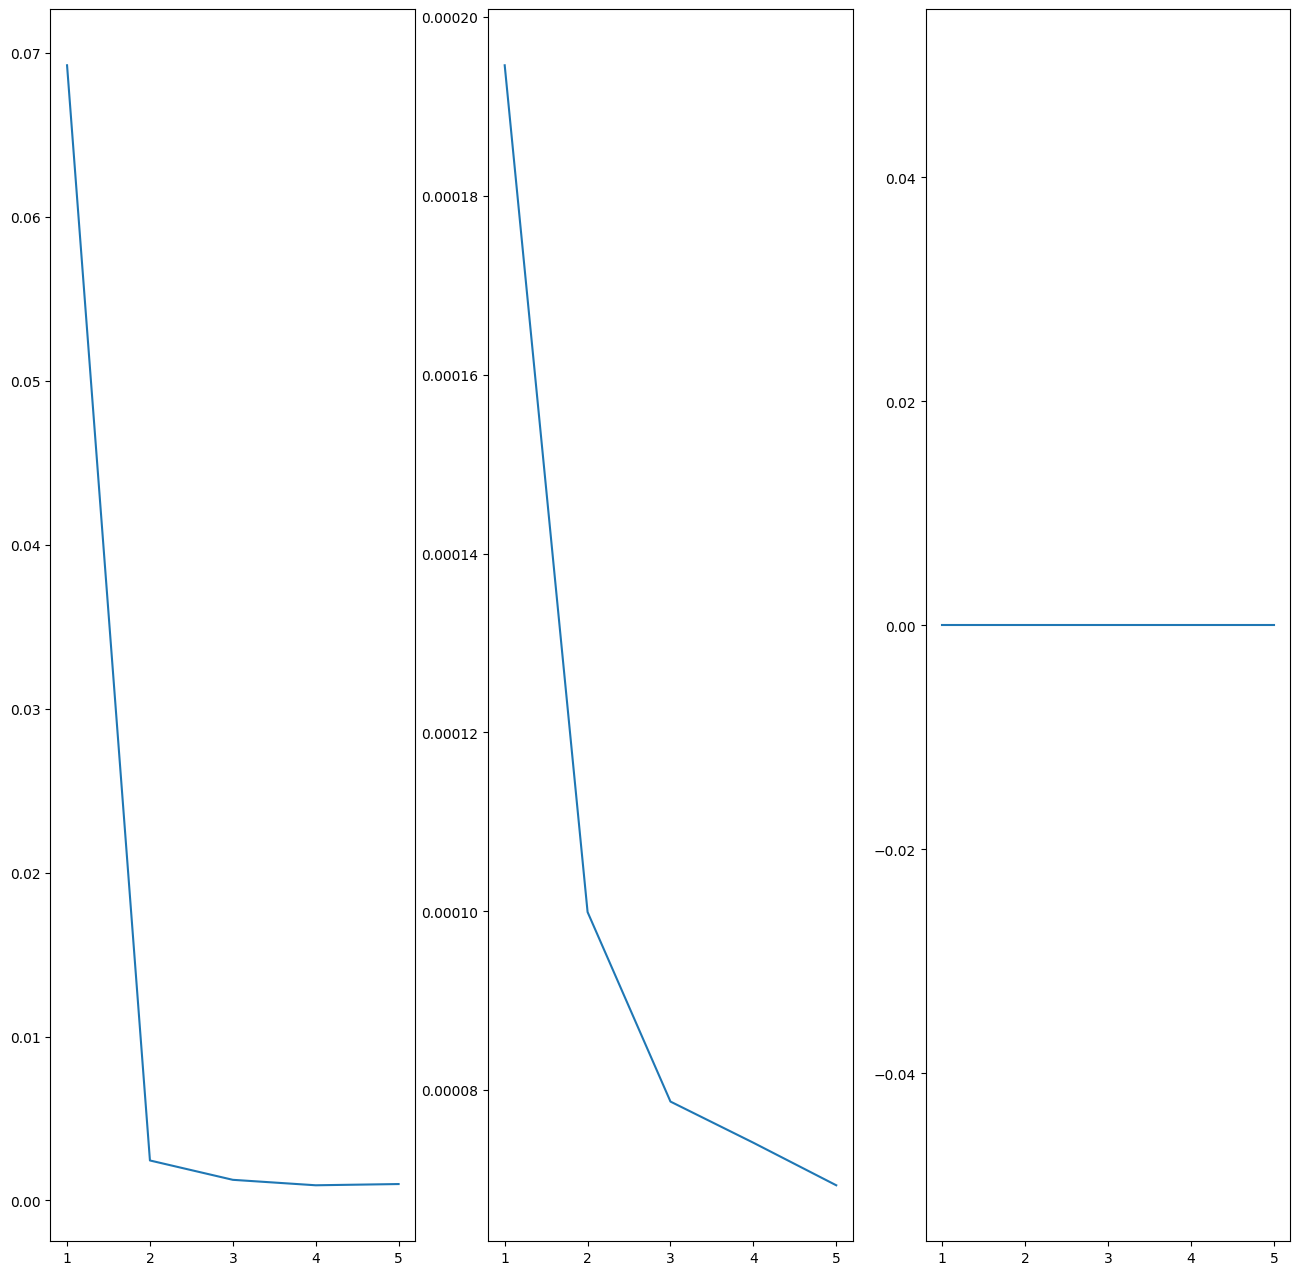

In [114]:
visualize(train_losses, val_losses, val_bleus)